In [1]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFE
from sklearn.datasets import load_boston
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import mglearn

/home/alex/3rd/py-venv/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/alex/3rd/py-venv/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# 第4章 数据表示与特征工程

数据点的描述方式有多种，包括：
- 连续特征(continuous feature)
- 分类特征(categorical feature)，也叫离散特征(discrete feature)

数据表示方式会对机器学习模型的性能产生巨大影响。

对于某个特定应用来说，如何找到最佳数据表示，这个问题被称为`特征工程(feature engineering)`，它是数据科学家和机器学习从业者在尝试解决现实世界问题时的主要任务之一。用正确的方式表示数据，对监督模型性能的影响比所选择的精确参数还要大。

## 4.1 分类变量
我们将使用美国成年人收入的`adult数据集`，该数据集的任务是预测一名工人的收入是高于$50000$美元还是低于$50000$美元。这个数据集的特征包括工人的年龄、雇用方式、教育水平、性别、每周工作时长、职业，等等。`表4-1`给出了该数据集中的前几个条目：

no|age|workclass|education|gender|hours-per-week|occupation|income
---|---|---|---|---|---|---|---
0|39|State-gov|Bachelors|Male|40|Adm-clerical|<=50K
1|50|Self-emp-not-inc|Bachelors|Male|13|Exec-managerial|<=50K
2|38|Private|HS-grad|Male|40|Handlers-cleaners|<=50K
3|53|Private|11th|Male|40|Handlers-cleaners|<=50K
4|28|Private|Bachelors|Female|40|Prof-specialty|<=50K
5|37|Private|Masters|Female|40|Exec-managerial|<=50K
6|49|Private|9th|Female|16|Other-service|<=50K
7|52|Self-emp-not-inc|HS-grad|Male|45|Exec-managerial|>50K
8|31|Private|Masters|Female|50|Prof-specialty|>50K
9|42|Private|Bachelors|Male|40|Exec-managerial|>50K
10|37|Private|Some-college|Male|80|Exec-managerial|>50K

这个任务属于分类任务，两个类别是收入$<=50k$和$>50k$。也可以预测具体收入，那样就变成了一个回归任务。但那样问题将变得更加困难，而理解$50K$的分界线本身也很有趣。

在这个数据集中，`age`和`hours-per-week`是连续特征，我们知道如何处理这种特征。但`workclass`、`education`、`gender`、`occupation`都是分类特征。

假设我们想要在这个数据上学习一个Logistic回归分类器。Logistic 回归利用下列公式进行预测：
- $\hat{y}=w[0]*x[0]+w[1]*x[1]+\cdots+w[p]*x[p]+b > 0$

其中$w[i]$和$b$是从训练集中学到的系数，$x[i]$是输入特征。当$x[i]$是数字时这个公式才有意义，但如果$x[2]$是"Masters"或"Bachelors"的话，这个公式则没有意义。显然，在应用Logistic回归时，我们需要换一种方式来表示数据。

### 4.1.1 One-Hot编码
表示分类变量最常用的方法就是使用`one-hot编码`或`N取1编码`，也叫`虚拟变量`(dummy variable)。虚拟变量背后的思想是将一个分类变量替换为一个或多个新特征，新特征取值为0和1。对于线性二分类(以及scikit-learn中其他所有模型)的公式而言，0和1这两个值是有意义的，我们可以像这样对每个类别引入一个新特征，从而表示任意数量的类别。

比如说，`workclass`特征的可能取值包括`Government Employee`、`Private Employee`、`Self Employed`和`Self Employed Incorporated`。为了编码这4个可能的取值，我们创建了4个新特征，分别叫作 `Government Employee`、`Private Employee`、`Self Employed`和`Self Employed Incorporated`，同时删除`workclass`特征。如果一个人的`workclass`取某个值，那么对应的特征取值为1，其他特征均取值为0。因此，对每个数据点来说，4个新特征中只有一个的取值为1。这就是它叫作`one-hot编码`或`N取1编码`的原因：

workclass|Government Employee|Private Employee|Self Employed|Self Employed Incorporated
---|---|---|---|---
Government Employee|1|0|0|0
Private Employee|0|1|0|0
Self Employed|0|0|1|0
Self Employed Incorporated|0|0|0|1

`one-hot编码`有两种方法：一种是使用`pandas`，一种是使用`scikit-learn`。使用`pandas`要稍微简单一些：

In [2]:
# 文件中没有包含列名称的表头，因此我们传入header=None
# 然后在"names"中显式地提供列名称
data = pd.read_csv("data/adult.data", header=None, index_col=False,
    names=['age', 'workclass', 'fnlwgt', 'education',  'education-num',
           'marital-status', 'occupation', 'relationship', 'race', 'gender',
           'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
           'income'])
# 为了便于说明，我们只选了其中几列
data = data[['age', 'workclass', 'education', 'gender', 'hours-per-week', 'occupation', 'income']]
display(data.head())

,age,workclass,education,gender,hours-per-week,occupation,income
0,39,State-gov,Bachelors,Male,40,Adm-clerical,<=50K
1,50,Self-emp-not-inc,Bachelors,Male,13,Exec-managerial,<=50K
2,38,Private,HS-grad,Male,40,Handlers-cleaners,<=50K
3,53,Private,11th,Male,40,Handlers-cleaners,<=50K
4,28,Private,Bachelors,Female,40,Prof-specialty,<=50K


#### 4.1.1.1 检查字符串编码的分类数据
编码之前要先确认每一列是否包含有意义的分类数据。在处理人工输入的数据时，可能没有固定的类别，拼写和大小写也存在差异，因此需要预处理。举个例子，有人可能将性别填为`male`，有人可能填为`man`，而我们希望能用同一个类别来表示这两种输入。`pandas Series`可以用了检查分类数据：

In [3]:
data.gender.value_counts()

 Male      21790
 Female    10771
Name: gender, dtype: int64

用`pandas`编码数据有一种非常简单的方法，就是使用`get_dummies函数`。`get_dummies函数`自动变换所有具有对象类型（比如字符串）的列或所有分类的列（这是`pandas`中的一个特殊概念，我们还没有讲到）：

In [4]:
print("Original features:\n", list(data.columns), "\n")
data_dummies = pd.get_dummies(data)
print("Features after get_dummies:\n", list(data_dummies.columns))

Original features:
 ['age', 'workclass', 'education', 'gender', 'hours-per-week', 'occupation', 'income'] 

Features after get_dummies:
 ['age', 'hours-per-week', 'workclass_ ?', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Never-worked', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_ 10th', 'education_ 11th', 'education_ 12th', 'education_ 1st-4th', 'education_ 5th-6th', 'education_ 7th-8th', 'education_ 9th', 'education_ Assoc-acdm', 'education_ Assoc-voc', 'education_ Bachelors', 'education_ Doctorate', 'education_ HS-grad', 'education_ Masters', 'education_ Preschool', 'education_ Prof-school', 'education_ Some-college', 'gender_ Female', 'gender_ Male', 'occupation_ ?', 'occupation_ Adm-clerical', 'occupation_ Armed-Forces', 'occupation_ Craft-repair', 'occupation_ Exec-managerial', 'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners', 'occupation_ Machine-op-i

可以看到，连续特征`age`和`hours-per-week`没有发生变化，而分类特征的每个可能取值都被扩展为一个新特征：

In [5]:
data_dummies.head()

,age,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,...,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,income_ <=50K,income_ >50K
0,39,40,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,50,13,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,38,40,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,53,40,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,28,40,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0


下面我们可以将`pandas DataFrame类型`的变量`data_dummies`转换为`NumPy`数组，然后在其上训练一个机器学习模型。

*在训练模型之前，注意要把目标变量(现在被编码为两个`income`列)从数据中分离出来。将输出变量或输出变量的一些导出属性包含在特征表示中，这是构建监督机器学习模型时一个非常常见的错误。*

> 注意：pandas 中的列索引包括范围的结尾，因此`'age':'occupation_Transport-moving'`中包括`occupation_Transport-moving`。这与NumPy数组的切片不同，后者不包括范围的结尾

在这个例子中，我们仅提取包含特征的列，也就是从`age`到`occupation_ Transport-moving`的所有列。这一范围包含所有特征，但不包含目标：

In [6]:
# 原文中使用了ix()，已经被loc()代替
features = data_dummies.loc[:, 'age':'occupation_ Transport-moving']
# 提取NumPy数组
X = features.values
y = data_dummies['income_ >50K'].values
print("X.shape: {}  y.shape: {}".format(X.shape, y.shape))

X.shape: (32561, 44)  y.shape: (32561,)


我们使用上面的数据测试一下LR模型：

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

print("Test score: {:.2f}".format(logreg.score(X_test, y_test)))

Test score: 0.81


/home/alex/3rd/py-venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


> 我们对同时包含训练数据和测试数据的数据集进行编码，这一点很重要，可以确保训练集和测试集中分类变量的表示方式相同。
> 
> 假设我们的训练集和测试集位于两个不同的数据框中。如果`workclass`特征的`Private Employee`取值没有出现在测试集中，那么`pandas`会认为这个特征只有3个可能的取值，因此只会创建3个新的虚拟特征。现在训练集和测试集的特征个数不相同，我们就无法将在训练集上学到的模型应用到测试集上。更糟糕的是，假设`workclass`特征在训练集中有`Government Employee`和`Private Employee`两个值，而在测试集中有`Self Employed`和`Self Employed Incorporated`两个值。在两种情况下，`pandas`都会创建两个新的虚拟特征，所以编码后的数据框的特征个数相同。但在训练集和测试集中的两个虚拟特征含义完全不同。

### 4.1.2 数字可以编码分类变量
在`adult数据集`的例子中，分类变量被编码为字符串。一方面，可能会有拼写错误；但另一方面，它明确地将一个变量标记为分类变量。现实中，分类变量通常被编码为整数。例如，假设`adult数据集`中，`workclass`的回答被记录为0(在第一个框打勾)、1(在第二个框打勾)、2(在第三个框打勾)，等等。如果有人观察表示数据集的表格，很难一眼看出这个变量应该被视为连续变量还是分类变量。

> 分类特征通常用整数进行编码。它们是数字并不意味着它们必须被视为连续特征。一个整数特征应该被视为连续的还是离散的(one-hot编码的)，有时并不明确。如果在被编码的语义之间没有顺序关系(比如`workclass`的例子)，那么特征必须被视为离散特征。对于其他情况(比如五星评分)，哪种编码更好取决于具体的任务和数据，以及使用哪种机器学习算法。

`pandas`的`get_dummies函数`将所有数字看作是连续的，不会为其创建虚拟变量。可以使用`scikit-learn`的`OneHotEncoder`，指定哪些变量是连续的、哪些变量是离散的，你也可以将数据框中的数值列转换为字符串：

In [8]:
demo_df = pd.DataFrame({'Integer Feature': [0, 1, 2, 1],
                        'Categorical Feature': ['socks', 'fox', 'socks', 'box']})
display(demo_df)

,Integer Feature,Categorical Feature
0,0,socks
1,1,fox
2,2,socks
3,1,box


使用`get_dummies`只会编码字符串特征，不会改变整数特征：

In [9]:
pd.get_dummies(demo_df)

,Integer Feature,Categorical Feature_box,Categorical Feature_fox,Categorical Feature_socks
0,0,0,0,1
1,1,0,1,0
2,2,0,0,1
3,1,1,0,0


如果你想为`Integer Feature`这一列创建虚拟变量，可以使用`columns参数`显式地给出想要编码的列。于是两个特征都会被当作分类特征处理：

In [10]:
demo_df['Integer Feature'] = demo_df['Integer Feature'].astype(str)
pd.get_dummies(demo_df, columns=['Integer Feature', 'Categorical Feature'])

,Integer Feature_0,Integer Feature_1,Integer Feature_2,Categorical Feature_box,Categorical Feature_fox,Categorical Feature_socks
0,1,0,0,0,0,1
1,0,1,0,0,1,0
2,0,0,1,0,0,1
3,0,1,0,1,0,0


## 4.2 分箱、离散化、线性模型与树
数据表示的最佳方法不仅取决于数据的语义，还取决于所使用的模型种类。线性模型与基于树的模型是两种成员很多同时又非常常用的模型，它们在处理不同的特征表示时就具有非常不同的性质。我们使用`wave回归数据集`，它只有一个输入特征。对比线性回归模型与决策树回归：

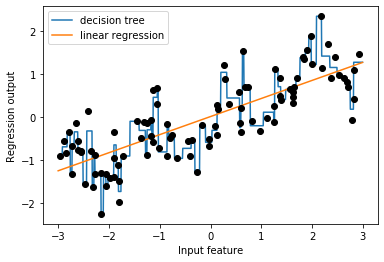

In [11]:
X, y = mglearn.datasets.make_wave(n_samples=100)
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

reg = DecisionTreeRegressor(min_samples_split=3).fit(X, y)
plt.plot(line, reg.predict(line), label="decision tree")

reg = LinearRegression().fit(X, y)
plt.plot(line, reg.predict(line), label="linear regression")

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")
plt.show()

线性模型对于单个特征的情况就是直线。决策树可以构建更为复杂的数据模型，但这强烈依赖于数据表示。有一种方法可以让线性模型在连续数据上变得更加强大，就是使用特征分箱(`binning`，也叫离散化，即`discretization`)将其划分为多个特征，如下所述。

我们假设将特征的输入范围(在这个例子中是从-3到3)划分成固定个数的箱子(bin)，比如 10 个，那么数据点就可以用它所在的箱子来表示：

In [12]:
bins = np.linspace(-3, 3, 11)
bins

array([-3. , -2.4, -1.8, -1.2, -0.6,  0. ,  0.6,  1.2,  1.8,  2.4,  3. ])

这里第一个箱子包含特征取值在-3到-2.4之间的所有数据点，第二个箱子包含特征取值在-2.4到-1.8之间的所有数据点，以此类推。

接下来，我们记录每个数据点所属的箱子：

In [13]:
which_bin = np.digitize(X, bins=bins)
print("\nData points:\n", X[:5])
print("\nBin membership for data points:\n", which_bin[:5])


Data points:
 [[-0.75275929]
 [ 2.70428584]
 [ 1.39196365]
 [ 0.59195091]
 [-2.06388816]]

Bin membership for data points:
 [[ 4]
 [10]
 [ 8]
 [ 6]
 [ 2]]


我们将`wave数据集`中单个连续输入特征变换为一个分类特征，用于表示数据点所在的箱子。要想在这个数据上使用`scikit-learn`模型，我们利用`preprocessing模块`的`OneHotEncoder`将这个离散特征变换为`one-hot编码`：

In [14]:
# 使用OneHotEncoder进行变换
encoder = OneHotEncoder(sparse=False)
# encoder.fit找到which_bin中的唯一值
encoder.fit(which_bin)
# transform创建one-hot编码
X_binned = encoder.transform(which_bin)
# 变换后的X_binned数据集现在包含10个特征
print(X_binned[:5])

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


/home/alex/3rd/py-venv/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


在`one-hot编码`后的数据上构建新的线性模型和新的决策树模型(图4-2)：

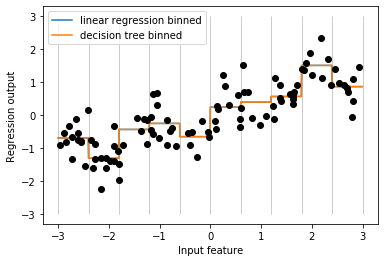

In [15]:
line_binned = encoder.transform(np.digitize(line, bins=bins))

reg = LinearRegression().fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='linear regression binned')

reg = DecisionTreeRegressor(min_samples_split=3).fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='decision tree binned')

plt.plot(X[:, 0], y, 'o', c='k')
plt.vlines(bins, -3, 3, linewidth=1, alpha=.2)
plt.legend(loc="best")
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.show()

两条线完全重合，说明线性回归模型和决策树做出了完全相同的预测。对于每个箱子，二者都预测一个常数值。因为每个箱子内的特征是不变的，所以对于一个箱子内的所有点，任何模型都会预测相同的值。比较对特征进行分箱前后模型学到的内容，我们发现，线性模型变得更加灵活了，因为现在它对每个箱子具有不同的取值，而决策树模型的灵活性降低了。

*分箱特征对基于树的模型通常不会产生更好的效果，因为这种模型可以学习在任何位置划分数据。从某种意义上来看，决策树可以学习如何分箱对预测这些数据最为有用。此外，决策树可以同时查看多个特征，而分箱通常针对的是单个特征。不过，线性模型的表现力在数据变换后得到了极大的提高。*

对于特定的数据集，如果有充分的理由使用线性模型——比如数据集很大、维度很高，但有些特征与输出的关系是非线性的——那么分箱是提高建模能力的好方法。



## 4.3 交互特征与多项式特征
想要丰富特征表示，特别是对于线性模型而言，另一种方法是添加原始数据的交互特征(interaction feature)和多项式特征(polynomial feature)。这种特征工程通常用于统计建模，但也常用于许多实际的机器学习应用中。

我们再看一次`图4-2`。线性模型对`wave数据集`中的每个箱子都学到一个常数值。但我们知道，线性模型不仅可以学习偏移，还可以学习斜率。想要向分箱数据上的线性模型添加斜率，一种方法是重新加入原始特征(图中的$x$轴)。这样会得到11维的数据集，如`图4-3`所示：

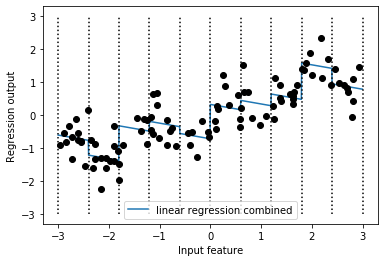

In [16]:
X_combined = np.hstack([X, X_binned])

reg = LinearRegression().fit(X_combined, y)

line_combined = np.hstack([line, line_binned])
plt.plot(line, reg.predict(line_combined), label='linear regression combined')

for bin in bins:
    plt.plot([bin, bin], [-3, 3], ':', c='k')

plt.legend(loc="best")
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.plot(X[:, 0], y, 'o', c='k')
plt.show()

模型在每个箱子中都学到一个偏移和一个斜率。学到的斜率是向下的，并且在所有箱子中都相同——只有一个$x$轴特征，也就只有一个斜率。因为斜率在所有箱子中是相同的，所以它似乎不是很有用。我们更希望每个箱子都有一个不同的斜率！为了实现这一点，我们可以添加交互特征或乘积特征，用来表示数据点所在的箱子以及数据点在$x$轴上的位置。这个特征是箱子指示符与原始特征的乘积。我们来创建数据集：

In [17]:
X_product = np.hstack([X_binned, X * X_binned])
X_product.shape

(100, 20)

数据集现在有20个特征：数据点所在箱子的指示符与原始特征和箱子指示符的乘积。你可以将乘积特征看作每个箱子$x$轴特征的单独副本。它在箱子内等于原始特征，在其他位置等于零。`图4-4`给出了线性模型在这种新表示上的结果：

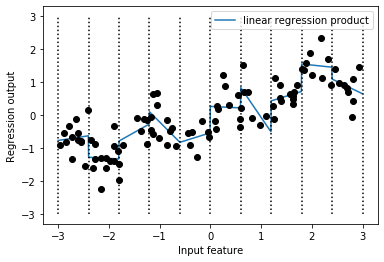

In [18]:
reg = LinearRegression().fit(X_product, y)

line_product = np.hstack([line_binned, line * line_binned])
plt.plot(line, reg.predict(line_product), label='linear regression product')

for bin in bins:
    plt.plot([bin, bin], [-3, 3], ':', c='k')

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")
plt.show()

使用分箱是扩展连续特征的一种方法。另一种方法是使用原始特征的多项式(polynomial)。对于给定特征$x$，我们可以考虑$x^2$、$x^3$、$x^4$，等等。这在`preprocessing模块`的`PolynomialFeatures`中实现：

In [19]:
# 包含直到x ** 10的多项式:
# 默认的"include_bias=True"添加恒等于1的常数特征
poly = PolynomialFeatures(degree=10, include_bias=False)
poly.fit(X)
X_poly = poly.transform(X)

print("X_poly.shape: {}\n".format(X_poly.shape))
print("Entries of X:\n{}\n".format(X[:3]))
print("Entries of X_poly:\n{}\n".format(X_poly[:3]))

# 通过get_feature_names()来获取特征的语义
print("Polynomial feature names:\n{}".format(poly.get_feature_names()))

X_poly.shape: (100, 10)

Entries of X:
[[-0.75275929]
 [ 2.70428584]
 [ 1.39196365]]

Entries of X_poly:
[[-7.52759287e-01  5.66646544e-01 -4.26548448e-01  3.21088306e-01
  -2.41702204e-01  1.81943579e-01 -1.36959719e-01  1.03097700e-01
  -7.76077513e-02  5.84199555e-02]
 [ 2.70428584e+00  7.31316190e+00  1.97768801e+01  5.34823369e+01
   1.44631526e+02  3.91124988e+02  1.05771377e+03  2.86036036e+03
   7.73523202e+03  2.09182784e+04]
 [ 1.39196365e+00  1.93756281e+00  2.69701700e+00  3.75414962e+00
   5.22563982e+00  7.27390068e+00  1.01250053e+01  1.40936394e+01
   1.96178338e+01  2.73073115e+01]]

Polynomial feature names:
['x0', 'x0^2', 'x0^3', 'x0^4', 'x0^5', 'x0^6', 'x0^7', 'x0^8', 'x0^9', 'x0^10']


将多项式特征与线性回归模型一起使用，可以得到经典的多项式回归(polynomial regression)模型(`图4-5`)：

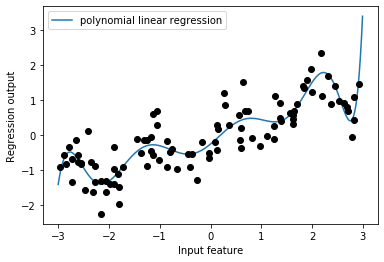

In [20]:
reg = LinearRegression().fit(X_poly, y)
line_poly = poly.transform(line)
plt.plot(line, reg.predict(line_poly), label='polynomial linear regression')
plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")
plt.show()

多项式特征在这个一维数据上得到了非常平滑的拟合。但高次多项式在边界上或数据很少的区域可能有极端的表现。

作为对比，下面是在原始数据上学到的`核SVM`模型，没有做任何变换(`图4-6`)：

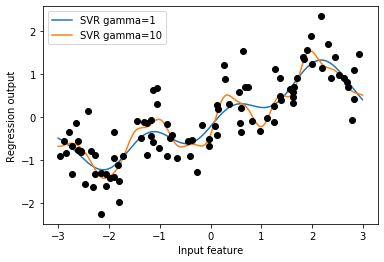

In [21]:
for gamma in [1, 10]:
    svr = SVR(gamma=gamma).fit(X, y)
    plt.plot(line, svr.predict(line), label='SVR gamma={}'.format(gamma))

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")
plt.show()

使用更加复杂的模型(即`核SVM`)，我们能够学到一个与多项式回归的复杂度类似的预测结果，且不需要进行显式的特征变换。

我们再次观察波士顿房价数据集，作为对交互特征和多项式特征更加实际的应用。我们在第2章已经在这个数据集上使用过多项式特征了。现在来看一下这些特征的构造方式，以及多项式特征的帮助有多大。首先加载数据，然后利用`MinMaxScaler`将其缩放到0和1之间：

In [22]:
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=0)

# 缩放数据
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 提取多项式特征和交互特征，次数最高为2
poly = PolynomialFeatures(degree=2).fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_poly.shape: {}".format(X_train_poly.shape))

X_train.shape: (379, 13)
X_train_poly.shape: (379, 105)


原始数据有13个特征，现在被扩展到105个交互特征。这些新特征表示两个不同的原始特征之间所有可能的交互项，以及每个原始特征的平方。这里$degree=2$的意思是，我们需要由最多两个原始特征的乘积组成的所有特征。利用`get_feature_names`方法可以得到输入特征和输出特征之间的确切对应关系：

In [23]:
print("Polynomial feature names:\n{}".format(poly.get_feature_names()))

Polynomial feature names:
['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x0 x11', 'x0 x12', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10', 'x1 x11', 'x1 x12', 'x2^2', 'x2 x3', 'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7', 'x2 x8', 'x2 x9', 'x2 x10', 'x2 x11', 'x2 x12', 'x3^2', 'x3 x4', 'x3 x5', 'x3 x6', 'x3 x7', 'x3 x8', 'x3 x9', 'x3 x10', 'x3 x11', 'x3 x12', 'x4^2', 'x4 x5', 'x4 x6', 'x4 x7', 'x4 x8', 'x4 x9', 'x4 x10', 'x4 x11', 'x4 x12', 'x5^2', 'x5 x6', 'x5 x7', 'x5 x8', 'x5 x9', 'x5 x10', 'x5 x11', 'x5 x12', 'x6^2', 'x6 x7', 'x6 x8', 'x6 x9', 'x6 x10', 'x6 x11', 'x6 x12', 'x7^2', 'x7 x8', 'x7 x9', 'x7 x10', 'x7 x11', 'x7 x12', 'x8^2', 'x8 x9', 'x8 x10', 'x8 x11', 'x8 x12', 'x9^2', 'x9 x10', 'x9 x11', 'x9 x12', 'x10^2', 'x10 x11', 'x10 x12', 'x11^2', 'x11 x12', 'x12^2']


第一个新特征是常数特征，这里的名称是`1`。接下来的13个特征是原始特征(名称从$x_0$到$x_{12}$)。然后是第一个特征的平方$x_0^2$以及它与其他特征的组合。

我们对`Ridge`在有交互特征的数据上和没有交互特征的数据上的性能进行对比：

In [24]:
ridge = Ridge().fit(X_train_scaled, y_train)
print("Score without interactions: {:.3f}".format(ridge.score(X_test_scaled, y_test)))

ridge = Ridge().fit(X_train_poly, y_train)
print("Score with interactions: {:.3f}".format(ridge.score(X_test_poly, y_test)))

Score without interactions: 0.621
Score with interactions: 0.753


在使用`Ridge`时，交互特征和多项式特征对性能有很大的提升。如果使用更加复杂的模型(比如随机森林)，你可以看到，即使没有额外的特征，随机森林的性能也要优于`Ridge`。添加交互特征和多项式特征实际上会略微降低其性能：

In [25]:
rf = RandomForestRegressor(n_estimators=100).fit(X_train_scaled, y_train)
print("Score without interactions: {:.3f}".format(rf.score(X_test_scaled, y_test)))

rf = RandomForestRegressor(n_estimators=100).fit(X_train_poly, y_train)
print("Score with interactions: {:.3f}".format(rf.score(X_test_poly, y_test)))

Score without interactions: 0.790
Score with interactions: 0.768


## 4.4 单变量非线性变换
[todo]看完《深入浅出统计学》之后有必要再看一遍本节。

添加特征的平方或立方可以改进线性回归模型。其他变换通常也对变换某些特征有用，特别是应用数学函数，比如`log`、`exp`或`sin`。虽然基于树的模型只关注特征的顺序，但线性模型和神经网络依赖于每个特征的尺度和分布。如果在特征和目标之间存在非线性关系，那么建模就变得非常困难，特别是对于回归问题。`log`和`exp`函数可以帮助调节数据的相对比例，从而改进线性模型或神经网络的学习效果。

> 我们在第2章中对内存价格数据应用过这种函数。在处理具有周期性模式的数据时，`sin`和`cos`函数非常有用。

大部分模型都在每个特征大致遵循高斯分布时表现最好，也就是说，每个特征的直方图应该具有类似于熟悉的“钟形曲线”的形状。使用诸如`log`和`exp`之类的变换并不稀奇，但却是实现这一点的简单又有效的方法。在一种特别常见的情况下，这样的变换非常有用，就是处理整数计数数据时。计数数据是指类似“用户A多长时间登录一次？”这样的特征。计数不可能取负值，并且通常遵循特定的统计模式。

下面我们使用一个模拟的计数数据集，其性质与在自然状态下能找到的数据集类似。特征全都是整数值，而响应是连续的。之后我们计算每个值的出现次数，看看数值的分布情况：

In [26]:
rnd = np.random.RandomState(0)
X_org = rnd.normal(size=(1000, 3))

w = rnd.normal(size=3)

X = rnd.poisson(10 * np.exp(X_org))
y = np.dot(X_org, w)

bins = np.bincount(X[:, 0])
print("Number of feature appearances:\n{}".format(bins))

Number of feature appearances:
[28 38 68 48 61 59 45 56 37 40 35 34 36 26 23 26 27 21 23 23 18 21 10  9
 17  9  7 14 12  7  3  8  4  5  5  3  4  2  4  1  1  3  2  5  3  8  2  5
  2  1  2  3  3  2  2  3  3  0  1  2  1  0  0  3  1  0  0  0  1  3  0  1
  0  2  0  1  1  0  0  0  0  1  0  0  2  2  0  1  1  0  0  0  0  1  1  0
  0  0  0  0  0  0  1  0  0  0  0  0  1  1  0  0  1  0  0  0  0  0  0  0
  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]


数字2似乎是最常见的，出现了68次(`bincount`始终从0开始)，更大数字的出现次数快速下降。但也有一些很大的数字，比如134出现了2次。我们在`图4-7`中将计数可视化：

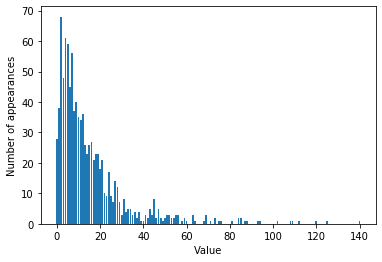

In [27]:
plt.bar(range(len(bins)), bins)
plt.ylabel("Number of appearances")
plt.xlabel("Value")
plt.show()

特征$X[:,1]$和$X[:,2]$具有类似的性质。这种类型的数值分布(即`泊松分布`，许多较小的值和一些非常大的值，对计数数据相当重要)在实践中非常常见。但大多数线性模型无法很好地处理这种数据。我们尝试拟合一个岭回归模型：

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
score = Ridge().fit(X_train, y_train).score(X_test, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.622


$R^2$分数较低，`Ridge`无法真正捕捉到$X$和$y$之间的关系。不过应用对数变换可能有用。由于数据取值中包括$0$，所以我们要计算$log(X+1)$。变换之后，数据分布的不对称性变小，也不再有非常大的异常值(见`图4-8`)：

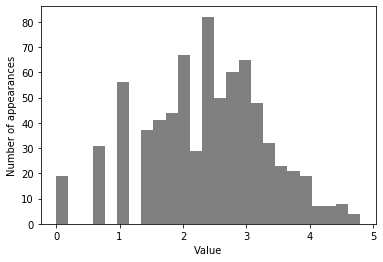

In [29]:
X_train_log = np.log(X_train + 1)
X_test_log = np.log(X_test + 1)

plt.hist(X_train_log[:, 0], bins=25, color='gray')
plt.ylabel("Number of appearances")
plt.xlabel("Value")
plt.show()

在新数据上构建一个岭回归模型，可以得到更好的拟合：

In [30]:
score = Ridge().fit(X_train_log, y_train).score(X_test_log, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.875


为数据集和模型的所有组合寻找最佳变换，这在某种程度上是一门艺术。在这个例子中，所有特征都具有相同的性质，这在实践中是非常少见的情况。通常来说，只有一部分特征应该进行变换，有时每个特征的变换方式也各不相同。前面提到过，对基于树的模型而言，这种变换并不重要，但对线性模型来说可能至关重要。

对回归的目标变量$y$进行变换有时也是一个好主意。尝试预测计数(比如订单数量)是一项相当常见的任务，而且使用$log(y+1)$变换也往往有用(是对泊松分布非常粗略的近似，而从概率的角度来看，这是正确的解决方法)。

从前面的例子中可以看出，分箱、多项式和交互项都对模型在给定数据集上的性能有很大影响，对于复杂度较低的模型更是这样，比如线性模型和朴素贝叶斯模型。与之相反，基于树的模型通常能够自己发现重要的交互项，大多数情况下不需要显式地变换数据。其他模型，比如`SVM`、`最近邻`和`神经网络`，有时可能会从使用分箱、交互项或多项式中受益，但其效果通常不如线性模型那么明显。

## 4.5 自动化特征选择
有了这么多种创建新特征的方法，你可能会想要增大数据的维度，使其远大于原始特征的数量。但是，添加更多特征会使所有模型变得更加复杂，从而增大过拟合的可能性。在添加新特征或处理一般的高维数据集时，最好将特征的数量减少到只包含最有用的那些特征，并删除其余特征。这样会得到泛化能力更好、更简单的模型。

但是如何判断每个特征的作用有多大呢？有三种基本的策略：
- 单变量统计(univariate statistics)
- 基于模型的选择(model-based selection)
- 迭代选择(iterative selection)

我们将详细讨论这三种策略。所有这些方法都是监督方法，即它们需要目标值来拟合模型。这也就是说，我们需要将数据划分为训练集和测试集，并只在训练集上拟合特征选择。

### 4.5.1 单变量统计
在单变量统计中，我们计算每个特征和目标值之间的关系是否存在统计显著性，然后选择具有最高置信度的特征。对于分类问题，这也被称为方差分析(analysis of variance，ANOVA)。这些测试的一个关键性质就是它们是单变量的(univariate)，即只单独考虑每个特征。因此，如果一个特征只有在与另一个特征合并时才具有信息量，那么这个特征将被舍弃。单变量测试的计算速度通常很快，并且不需要构建模型。另一方面，它们完全独立于你可能想要在特征选择之后应用的模型。

想要在`scikit-learn`中使用单变量特征选择，你需要选择一项测试：对分类问题通常是`f_classif`(默认值)，对回归问题通常是`f_regression`，然后基于测试中确定的$p$值来选择一种舍弃特征的方法。所有舍弃参数的方法都使用阈值来舍弃所有$p$值过大的特征(意味着它们不可能与目标值相关)。计算阈值的方法各有不同，最简单的是`SelectKBest`和`SelectPercentile`，前者选择固定数量的$k$个特征，后者选择固定百分比的特征。

我们将分类的特征选择应用于`cancer数据集`。为了使任务更难一点，我们将向数据中添加一些没有信息量的噪声特征。我们期望特征选择能能够识别没有信息量的特征并删除它们：

In [31]:
cancer = load_breast_cancer()

# 获得确定性的随机数
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))

# 向数据中添加噪声特征
# 前30个特征来自数据集，后50个是噪声
X_w_noise = np.hstack([cancer.data, noise])

X_train, X_test, y_train, y_test = train_test_split(X_w_noise, cancer.target, random_state=0, test_size=.5)

# 使用f_classif（默认值）和SelectPercentile来选择50%的特征
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)

# 对训练集进行变换
X_train_selected = select.transform(X_train)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

X_train.shape: (284, 80)
X_train_selected.shape: (284, 40)


特征的数量从80减少到40。我们可以用`get_support`方法来查看哪些特征被选中，它会返回所选特征的布尔遮罩(其可视化见图 4-9)：

In [32]:
mask = select.get_support()
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False,  True, False,  True,
       False, False,  True, False, False, False, False,  True, False,
       False,  True, False, False,  True, False,  True, False, False,
       False, False, False, False,  True, False,  True, False, False,
       False, False,  True, False,  True, False, False, False, False,
        True,  True, False,  True, False, False, False, False])

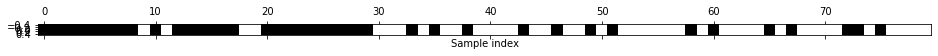

In [33]:
# 将遮罩可视化——黑色为True，白色为False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.show()

从遮罩的可视化中看出，大多数噪声特征都已被删除，但原始特征的还原并不完美。我们来比较`Logistic回归`在所有特征上的性能与仅使用所选特征的性能：

In [34]:
# 对测试数据进行变换
X_test_selected = select.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train, y_train)
print("Score with all features: {:.3f}".format(lr.score(X_test, y_test)))

lr.fit(X_train_selected, y_train)
print("Score with only selected features: {:.3f}".format(lr.score(X_test_selected, y_test)))

Score with all features: 0.930
Score with only selected features: 0.940


/home/alex/3rd/py-venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/alex/3rd/py-venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


在这个例子中，删除噪声特征可以提高性能，即使丢失了某些原始特征。这是一个非常简单的假想示例，在真实数据上的结果要更加复杂。不过，如果特征量太大以至于无法构建模型，或者你怀疑许多特征完全没有信息量，那么单变量特征选择还是非常有用的。

### 4.5.2 基于模型的特征选择
基于模型的特征选择使用一个监督机器学习模型来判断每个特征的重要性，并且仅保留最重要的特征。用于特征选择的监督模型不需要与用于最终监督建模的模型相同。特征选择模型需要为每个特征提供某种重要性度量，以便用这个度量对特征进行排序。

决策树和基于决策树的模型提供了`feature_importances_`属性，可以直接编码每个特征的重要性。线性模型系数的绝对值也可以用于表示特征重要性。$L1$惩罚的线性模型学到的是稀疏系数，它只用到了特征的一个很小的子集。这可以被视为模型本身的一种特征选择形式，但也可以用作另一个模型选择特征的预处理步骤。

与单变量选择不同，基于模型的选择同时考虑所有特征，因此可以获取交互项(如果模型能够获取它们的话)。要想使用基于模型的特征选择，我们需要使用`SelectFromModel变换器`。`SelectFromModel`类选出重要性度量(由监督模型提供)大于给定阈值的所有特征。为了得到可以与单变量特征选择进行对比的结果，我们使用中位数作为阈值，这样就可以选择一半特征。

我们用包含$100$棵树的随机森林分类器来计算特征重要性。这是一个相当复杂的模型，也比单变量测试要强大得多：

X_train.shape: (284, 80)
X_train_l1.shape: (284, 40)


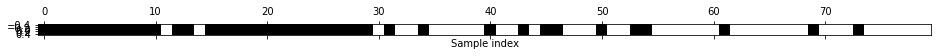

In [35]:
select = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold="median")

select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_l1.shape: {}".format(X_train_l1.shape))

mask = select.get_support()
# 将遮罩可视化——黑色为True，白色为False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.show()

除了两个原始特征，其他原始特征都被选中。我们来看一下其性能：

In [36]:
X_test_l1 = select.transform(X_test)
score = LogisticRegression().fit(X_train_l1, y_train).score(X_test_l1, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.951


/home/alex/3rd/py-venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### 4.5.3 迭代特征选择
在基于模型的选择中，我们使用了单个模型来选择特征。在迭代特征选择中，将会构建一系列模型，每个模型都使用不同数量的特征。

有两种基本方法：
1. 开始时没有特征，然后逐个添加特征，直到满足某个终止条件
2. 从所有特征开始，然后逐个删除特征，直到满足某个终止条件

由于构建了一系列模型，所以这些方法的计算成本要比前面讨论过的方法更高。其中一种特殊方法是递归特征消除(recursive feature elimination，RFE)，它从所有特征开始构建模型，并根据模型舍弃最不重要的特征，然后使用除被舍弃特征之外的所有特征来构建一个新模型，如此继续，直到仅剩下预设数量的特征。为了让这种方法能够运行，用于选择的模型需要提供某种确定特征重要性的方法，正如基于模型的选择所做的那样。下面我们使用之前用过的同一个随机森林模型，得到的结果如`图4-11`所示：

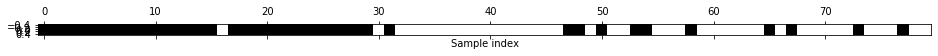

In [37]:
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42),
             n_features_to_select=40)
select.fit(X_train, y_train)

# 将选中的特征可视化：
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.show()

与单变量选择和基于模型的选择相比，迭代特征选择的结果更好，但仍然漏掉了一个特征。运行上述代码需要的时间也比基于模型的选择长得多，因为对一个随机森林模型训练了40次，每运行一次删除一个特征。我们来测试一下使用`RFE`做特征选择时`Logistic回归`模型的精度：

In [38]:
X_train_rfe= select.transform(X_train)
X_test_rfe= select.transform(X_test)

score = LogisticRegression().fit(X_train_rfe, y_train).score(X_test_rfe, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.951


/home/alex/3rd/py-venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


我们还可以利用在`RFE`内使用的模型来进行预测。这仅使用被选中的特征集：

In [39]:
print("Test score: {:.3f}".format(select.score(X_test, y_test)))

Test score: 0.951


在`RFE`内部使用的随机森林的性能，与在所选特征上训练一个`Logistic回归`模型得到的性能相同。换句话说，只要我们选择了正确的特征，线性模型的表现就与随机森林一样好。

**如果你不确定何时选择使用哪些特征作为机器学习算法的输入，那么自动化特征选择可能特别有用。它还有助于减少所需要的特征数量，加快预测速度，或允许可解释性更强的模型。在大多数现实情况下，使用特征选择不太可能大幅提升性能，但它仍是特征工程工具箱中一个非常有价值的工具。**

## 4.6 利用专家知识
对于特定应用来说，在特征工程中通常可以利用`专家知识`(expert knowledge)。虽然在许多情况下，机器学习的目的是避免创建一组专家设计的规则，但这并不意味着应该舍弃该应用或该领域的先验知识。通常来说，领域专家可以帮助找出有用的特征，其信息量比数据原始表示要大得多。

想象一下，你在一家旅行社工作，想要预测机票价格。假设你有价格以及日期、航空公司、出发地和目的地的记录。机器学习模型可能从这些记录中构建一个相当不错的模型，但可能无法学到机票价格中的某些重要因素。例如，在度假高峰月份和假日期间，机票价格通常更高。虽然某些假日的日期是固定的，其影响可以从日期中学到，但其他假日的日期可能取决于月相(比如光明节和复活节)，或者由官方规定(比如学校放假)。如果每个航班都只使用公历记录日期，则无法从数据中学到这些事件。但添加一个特征是很简单的，其中编码了一个航班在公休假日或学校假期的之前、之中还是之后。利用这种方法可以将关于任务属性的先验知识编码到特征中，以辅助机器学习算法。添加一个特征并不会强制机器学习算法使用它，即使最终发现假日信息不包含关于机票价格的信息，用这一信息来扩充数据也不会有什么害处。

下面我们来看一个利用专家知识的特例——虽然在这个例子中，对这些专家知识更正确的叫法应该是“常识”。任务是预测在`Andreas`家门口的自行车出租。

在纽约，`Citi Bike`运营着一个带有付费系统的自行车租赁站网络。这些站点遍布整个城市，提供了一种方便的交通方式。[自行车出租数据以匿名形式公开](https://www.citibikenyc.com/system-data)，并用各种方法进行了分析。我们想要解决的任务是，对于给定的日期和时间，预测有多少人将会在`Andreas`的家门口租一辆自行车——这样他就知道是否还有自行车留给他。

我们首先将这个站点2015年8月的数据加载为一个 pandas 数据框。我们将数据重新采样为每3小时一个数据，以得到每一天的主要趋势：

In [40]:
citibike = mglearn.datasets.load_citibike()
citibike.head()

starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64

下面这个示例给出了整个月租车数量的可视化(`图4-12`)：

/home/alex/3rd/py-venv/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


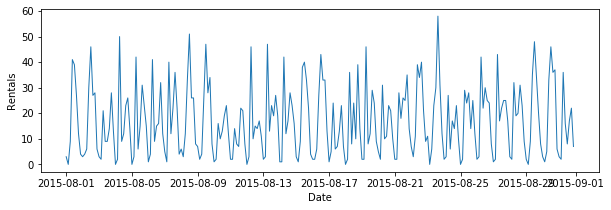

In [41]:
plt.figure(figsize=(10, 3)) 
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(), freq='D')

# 原文的这行代码在jupyter运行不了，改成后面一行的方式，但在独立终端可以
# plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation=90, ha="left")
plt.xlabel("Date")
plt.ylabel("Rentals")
plt.plot(citibike, linewidth=1)
plt.show()

观察此数据，我们可以清楚地区分每24小时中的白天和夜间。工作日和周末的模式似乎也有很大不同。在对这种时间序列上的预测任务进行评估时，我们通常希望从过去学习并预测未来。也就是说，在划分训练集和测试集的时候，我们希望使用某个特定日期之前的所有数据作为训练集，该日期之后的所有数据作为测试集。这是我们通常使用时间序列预测的方式：已知过去所有的出租数据，我们认为明天会发生什么？

我们将使用前$184$个数据点(对应前$23$天)作为训练集，剩余的$64$个数据点(对应剩余的$8$天)作为测试集。

在我们的预测任务中，我们使用的唯一特征就是某一租车数量对应的日期和时间。因此输入特征是日期和时间，比如`2015-08-01 00:00:00`，而输出是在接下来3小时内的租车数量。

在计算机上存储日期的常用方式是使用`POSIX时间`，它是从`1970年1月1日 00:00:00`起至现在的总秒数。首先，我们可以尝试使用这个单一整数特征作为数据表示，之后再构建模型：

Test-set R^2: -0.04


<Figure size 432x288 with 0 Axes>

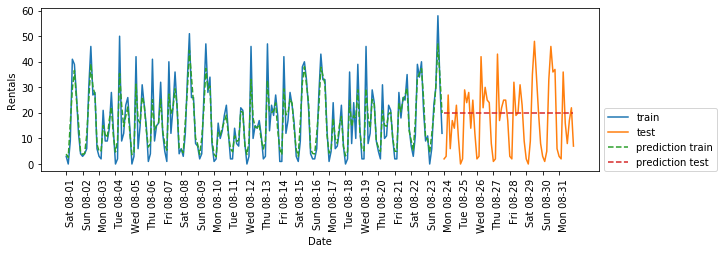

In [42]:
# 提取目标值（租车数量）
y = citibike.values
# 利用"%s"将时间转换为POSIX时间
X = citibike.index.strftime("%s").astype("int").values.reshape(-1, 1)

# 使用前184个数据点用于训练，剩余的数据点用于测试
n_train = 184

# 对给定特征集上的回归进行评估和作图的函数
def eval_on_features(features, target, regressor):
    # 将给定特征划分为训练集和测试集
    X_train, X_test = features[:n_train], features[n_train:]
    # 同样划分目标数组
    y_train, y_test = target[:n_train], target[n_train:]
    regressor.fit(X_train, y_train)
    print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test)))
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    plt.figure(figsize=(10, 3))

    plt.xticks(range(0, len(X), 8), xticks.strftime("%a %m-%d"), rotation=90, ha="left")

    plt.plot(range(n_train), y_train, label="train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="test")
    plt.plot(range(n_train), y_pred_train, '--', label="prediction train")
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label="prediction test")
    plt.legend(loc=(1.01, 0))
    plt.xlabel("Date")
    plt.ylabel("Rentals")

regressor = RandomForestRegressor(n_estimators=100, random_state=0)
plt.figure()
eval_on_features(X, y, regressor)
plt.show()

在训练集上的预测结果相当好，这符合随机森林通常的表现。但对于测试集来说，预测结果是一条常数直线。$R^2$为$-0.04$，说明我们什么都没有学到。发生了什么？

问题在于特征和随机森林的组合。测试集中时间特征的值超出了训练集中特征取值的范围：测试集中数据点的时间戳要晚于训练集中的所有数据点。树以及随机森林无法外推到训练集之外的特征范围。结果就是模型只能预测训练集中最近数据点的目标值，即最后一次观测到数据的时间。

显然，我们可以做得更好。这就是我们的“专家知识”的用武之地。通过观察训练数据中的租车数量图像，我们发现两个因素似乎非常重要：一天内的时间与一周的星期几。因此我们来添加这两个特征。我们从`POSIX时间`中学不到任何东西，所以删掉这个特征。首先，我们仅使用每天的时刻。如图 4-14 所示，现在的预测结果对一周内的每天都具有相同的模式：

Test-set R^2: 0.60


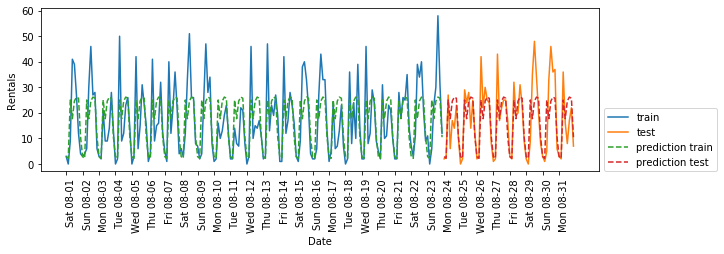

In [43]:
X_hour = citibike.index.hour.astype("int64").values.reshape(-1, 1) 
eval_on_features(X_hour, y, regressor)
plt.show()

$R^2$已经好多了，但预测结果显然没有抓住每周的模式。下面我们还添加一周的星期几作为特征(见`图4-15`):

Test-set R^2: 0.84


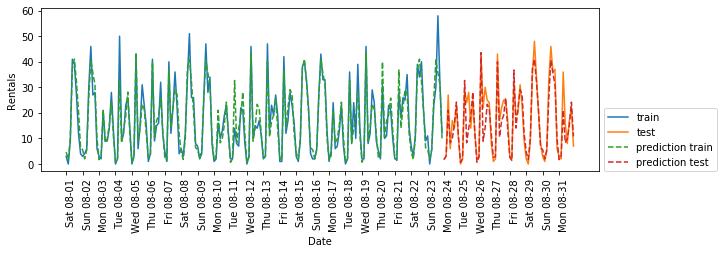

In [44]:
X_hour_week = np.hstack([citibike.index.dayofweek.astype("int64").values.reshape(-1, 1), 
                         citibike.index.hour.astype("int64").values.reshape(-1, 1)]) 
eval_on_features(X_hour_week, y, regressor)
plt.show()

现在我们的模型通过考虑一周的星期几和一天内的时间捕捉到了周期性的行为。它的$R^2$为$0.84$，预测性能相当好。模型学到的内容可能是$8$月前$23$天中星期几与时刻每种组合的平均租车数量。这实际上不需要像随机森林这样复杂的模型，所以我们尝试`LinearRegression`(见`图4-16`)：

Test-set R^2: 0.13


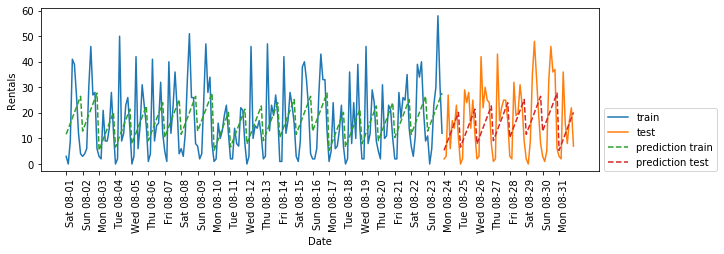

In [45]:
eval_on_features(X_hour_week, y, LinearRegression())
plt.show()

`LinearRegression`的效果差得多，其原因在于我们用整数编码一周的星期几和一天内的时间，它们被解释为连续变量。因此，线性模型只能学到关于每天时间的线性函数——它学到的是，时间越晚，租车数量越多。但实际模式比这要复杂得多。我们可以通过将整数解释为分类变量(见`图4-17`)：

/home/alex/3rd/py-venv/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Test-set R^2: 0.62


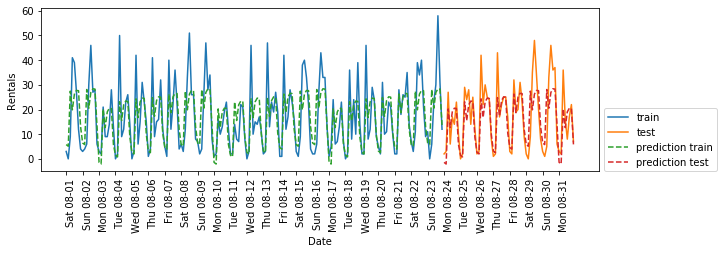

In [46]:
enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()
eval_on_features(X_hour_week_onehot, y, Ridge())
plt.show()

它给出了比连续特征编码好得多的匹配。现在线性模型为一周内的每天都学到了一个系数，为一天内的每个时刻都学到了一个系数。也就是说，一周七天共享“一天内每个时刻”的模式。

利用交互特征，我们可以让模型为星期几和时刻的每一种组合学到一个系数(见`图4-18`)：

Test-set R^2: 0.85


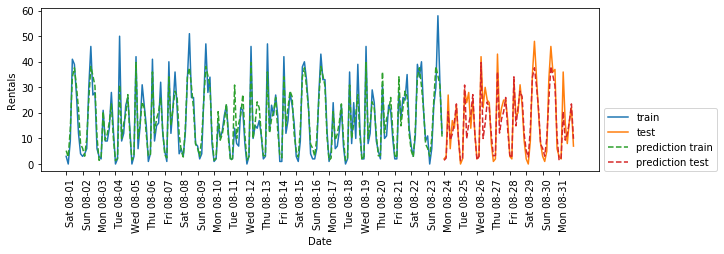

In [47]:
poly_transformer = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)

lr = Ridge()
eval_on_features(X_hour_week_onehot_poly, y, lr)
plt.show()

这一变换最终得到一个性能与随机森林类似的模型。这个模型的一大优点是，可以很清楚地看到学到的内容：对每个星期几和时刻的交互项学到了一个系数。我们可以将模型学到的系数作图，而这对于随机森林来说是不可能的。

首先，为时刻和星期几特征创建特征名称：

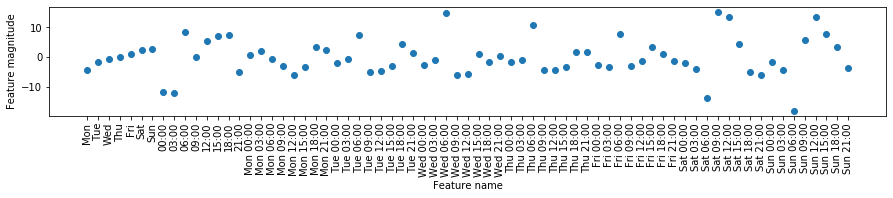

In [48]:
hour = ["%02d:00" % i for i in range(0, 24, 3)]
day = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
features =  day + hour

features_poly = poly_transformer.get_feature_names(features)
features_nonzero = np.array(features_poly)[lr.coef_ != 0]
coef_nonzero = lr.coef_[lr.coef_ != 0]

plt.figure(figsize=(15, 2))
plt.plot(coef_nonzero, 'o')
plt.xticks(np.arange(len(coef_nonzero)), features_nonzero, rotation=90)
plt.xlabel("Feature name")
plt.ylabel("Feature magnitude")
plt.show()

## 4.7 小结与展望
本章讨论了如何处理不同的数据类型(特别是分类变量)。我们强调了使用适合机器学习算法的数据表示方式的重要性，例如`one-hot编码`过的分类变量。还讨论了通过特征工程生成新特征的重要性，以及利用专家知识从数据中创建导出特征的可能性。特别是线性模型，可能会从分箱、添加多项式和交互项而生成的新特征中大大受益。对于更加复杂的非线性模型(比如随机森林和SVM)，在无需显式扩展特征空间的前提下就可以学习更加复杂的任务。在实践中，所使用的特征(以及特征与方法之间的匹配)通常是使机器学习方法表现良好的最重要的因素。

现在你已经知道了如何适当地表示数据，以及对哪个任务使用哪种算法，下一章节重点介绍评估机器学习模型的性能与选择正确的参数设置。